### questions from TJC
 - can we get estimates/error bars from wihtin individuals when it comes to dating admixture
 - can we get individual admixture ages per country (maybe a boxplot).
 - test for selection consider using the same ones from the previous paper and/or iHS.

# Ancestry *S.haematobium* vs. *S. bovis* across Africa (SCAN)

Neal Platt 2021

# Prep envrinoment and data for analyses

use the `scan_selection` conda environment

In [1]:
import os
import allel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
import statsmodels.stats.multitest as smm
import scipy.stats as stats
from pathlib import Path
from matplotlib.colors import ListedColormap
# from itertools import groupby
# import seaborn as sns
# import pickle
# #from collections import Counter
# from IPython.display import Image 
# import glob
# #import pybedtools
# import gffutils
# from scipy.signal import medfilt
from collections import defaultdict
from intervaltree import Interval, IntervalTree
#import vcf
#import loter.locanc.local_ancestry as lc
from IPython.display import Image

In [2]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir=f"{proj_dir}/results"
os.chdir(results_dir)

## Get sample info

In [3]:
sample_info_df = pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir))

In [4]:
sample_info_df

,admera_id,barcode_label_ID,library_id,sample_name,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon
0,19047FL-14-02-03,MCF03050E0612,na,sha_angola_cota_57,SRR11907442,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
1,19047FL-14-02-04,MCF03050E0613,na,sha_angola_cota_58,SRR11907441,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
2,19047FL-14-02-05,MCF03050E0614,na,sha_angola_cota_59,SRR11907440,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
3,19047FL-14-02-06,MCF03050E0615,na,sha_angola_icau_60,SRR11907439,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
4,19047FL-14-02-07,MCF03050E0615,na,sha_angola_icau_61,SRR11907438,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,na,na,na,sh_egypt_SRR433862,SRR433862,s_haematobium,egypt,na,na,haematobium,Rey_2019,genome,NaN,NaN
445,na,na,na,sh_gambia_SRR13579872,SRR13579872,s_haematobium,gambia,na,na,haematobium,Rey_2019,genome,NaN,NaN
446,na,na,na,sh_ivorycoast_SRR13579866,SRR13579866,s_haematobium,cote_d_ivoire,na,na,haematobium,Rey_2019,genome,NaN,NaN
447,na,na,na,sh_madagascar_SRR13579871,SRR13579871,s_haematobium,madagascar,na,na,haematobium,Rey_2019,genome,NaN,NaN


## Read in data and get allele counts

In [181]:
#read in the vcf file
filtered_callset=allel.read_vcf(f'{results_dir}/post_phase_filtering/autosomes_unrelated.vcf')

In [182]:
#get relevant info
gt      = allel.GenotypeArray(filtered_callset['calldata/GT'])
chroms  = filtered_callset["variants/CHROM"]
samples = filtered_callset["samples"]
poss    = filtered_callset["variants/POS"]
var_ids = filtered_callset["variants/ID"]

uniq_chroms=np.unique(chroms)

In [183]:
#read in pca df since it has species ids and kmeans labels
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
pca_df["country"] = pca_df["country"].astype(str)

In [184]:
pca_df.loc[ (pca_df["kmeans_label"] == "sh_nw") & 
            (pca_df["project"] == "scan_africa")]

,sample_name,1,2,3,4,5,6,7,8,9,...,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species,kmeans_label
29,sbo_cdivoire_raviart_108,0.021400,-0.070582,-0.045198,0.206487,0.004450,0.012315,0.028276,-0.103222,-0.100459,...,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0,s_haematobium,sh_nw
30,sbo_cdivoire_raviart_109,0.020538,-0.076418,-0.046554,0.226617,-0.003926,-0.014860,-0.011537,-0.087275,-0.110759,...,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0,s_haematobium,sh_nw
31,sbo_niger_libore_154,0.025617,-0.079330,-0.013864,-0.055163,-0.001331,-0.003984,0.000089,-0.016355,0.055014,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
32,sbo_niger_libore_155,0.021715,-0.077734,-0.013288,-0.061101,0.008696,-0.056704,0.051375,-0.009732,0.050136,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
33,sbo_niger_libore_160,0.021868,-0.075221,-0.018740,-0.071181,-0.001439,-0.055054,0.051839,-0.075687,0.004744,...,na,snail,unk,scan_africa,genome,13.388050,2.199130,0,s_haematobium,sh_nw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,ssp_niger_libore_166,0.022455,-0.078463,-0.021334,-0.066131,0.005504,-0.046551,0.052623,-0.059921,0.043647,...,na,snail,unk,scan_africa,genome,13.388050,2.199130,0,s_haematobium,sh_nw
166,ssp_niger_libore_167,0.023576,-0.078099,-0.011150,-0.061000,0.017043,-0.045486,0.040388,-0.017674,0.024366,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
167,ssp_niger_libore_168,0.022321,-0.076938,-0.018901,-0.060000,0.006243,-0.004137,0.029055,-0.042276,0.080228,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
168,ssp_niger_libore_169,0.023969,-0.073719,-0.019718,-0.050199,0.016409,-0.015895,0.038597,-0.020768,0.037634,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw


### Species

In [185]:
#get species idxs
sp_idxs = {}
sp_acs  = {}

for sp in tqdm(["s_bovis", "s_haematobium"]):
    
    #find indecies for each sample from that species
    names = pca_df.loc[pca_df["pca_species"] ==  sp, "sample_name"]
    sp_idxs[sp]=np.in1d(samples, names).nonzero()[0]

    #get allele counts for each species
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:20<00:00, 10.25s/it]


In [186]:
#add outgroups
s_guineensis   = "guineensis_saotome_ERR119612"
s_intercalatum = "intercalatum_drcongo_ERR119613"
s_margrebowiei = "margrebowiei_zambia_ERR310940"
s_matthei      = "matthei_zambia_ERR103051"

outgroups=[s_guineensis, s_intercalatum, s_margrebowiei, s_matthei]


In [187]:
for sp in tqdm(outgroups):
    sp_idxs[sp] = [list(samples).index(sp)]
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.23s/it]


### Kmeans group

In [188]:
#get species idxs
k_pop_idxs = {}
k_pop_acs  = {}

for k in tqdm(pca_df["kmeans_label"].unique()):
    
    #find indecies for each sample per k population
    ks = pca_df.loc[pca_df["kmeans_label"] ==  k, "sample_name"]
    k_pop_idxs[k]=np.in1d(samples, ks).nonzero()[0]
    
    #get allele counts for k group
    k_pop_acs[k] = gt.count_alleles(subpop=k_pop_idxs[k])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:27<00:00,  3.90s/it]


In [189]:
major_acs={"sh_nw":          k_pop_acs["sh_nw"],
           "sh_se":          k_pop_acs["sh_se"],
           "sb":             k_pop_acs["sb"] ,
           "sh":             sp_acs["s_haematobium"],
           "s_guineensis":   sp_acs["guineensis_saotome_ERR119612"],
           "s_intercalatum": sp_acs["intercalatum_drcongo_ERR119613"],
           "s_margrebowiei": sp_acs["margrebowiei_zambia_ERR310940"],
           "s_matthei":      sp_acs["matthei_zambia_ERR103051"]  }

# Selscan

In [5]:
Path("{}/selscan".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/selscan".format(results_dir))

In [6]:
!ln -s ../post_phase_filtering/chrs_unrelated.vcf

In [39]:
#samples with no lat/lon info cause major problems will need to exclude downstream
sh_nw_samples = pca_df.loc[pca_df["kmeans_label"] == "sh_nw", "sample_name" ].values
sh_se_samples = pca_df.loc[pca_df["kmeans_label"] == "sh_se", "sample_name" ].values
sb_samples    = pca_df.loc[pca_df["kmeans_label"] == "sb"   , "sample_name" ].values

np.savetxt("nw.list", sh_nw_samples, delimiter=',', fmt="%s")
np.savetxt("se.list", sh_se_samples, delimiter=',', fmt="%s")
np.savetxt("sb.list", sb_samples, delimiter=',', fmt="%s")

In [ ]:
%%bash 

vcftools \
    --vcf chrs_unrelated.vcf \
    --keep nw.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >nw.vcf

In [ ]:
%%bash 

vcftools \
    --vcf chrs_unrelated.vcf \
    --keep se.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >se.vcf

In [ ]:
%%bash 

vcftools \
    --vcf chrs_unrelated.vcf \
    --keep sb.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >sb.vcf

In [ ]:
cat nw.list se.list >sh.list

vcftools \
    --vcf chrs_unrelated.vcf \
    --keep sh.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >sh.vcf

In [ ]:
#create a map file
#< chr # > <id > < genetic position > < physical position >

 cut -f1-3 chrs_unrelated.vcf | grep -v "#" | awk '{print $1"\t"$3"\t"$2/287000"\t"$2}' >selscan.map

In [ ]:
for CHROM in "NC_067195.1" "NC_067196.1" "NC_067197.1" "NC_067198.1" "NC_067199.1" "NC_067200.1" "NC_067201.1" "NC_067202.1"; do
    for POP in "nw" "sh" "se" "sb"; do
        conda run -n scan_selection --cwd . --live-stream vcftools --vcf ${POP}.vcf --chr ${CHROM} --recode --recode-INFO-all --stdout >${POP}_${CHROM}.vcf &
    done
done

In [ ]:
#./selscan/bin/linux/selscan --xpehh --unphased --vcf nw_${CHROM}.vcf  --vcf-ref se_${CHROM}.vcf --map selscan.map --out nw_vs_se_ref_${CHROM} --threads 12 --pmap

In [ ]:
QUERY="nw"
REF="se"

for CHROM in "NC_067195.1" "NC_067196.1" "NC_067197.1" "NC_067198.1" "NC_067199.1" "NC_067200.1" "NC_067201.1" "NC_067202.1"; do
    
    JID="${QUERY}-query_vs_${REF}-ref_${CHROM}_unphased"
    VCF="${QUERY}_${CHROM}.vcf"
    REF_VCF="${REF}_${CHROM}.vcf"
    THREADS="12"
    
    CMD="conda run -n scan_selection --cwd . --live-stream ./selscan/bin/linux/selscan --xpehh --unphased --vcf ${VCF} --vcf-ref ${REF_VCF} --map selscan.map --out ${JID} --threads ${THREADS} --pmap"
    
    QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp ${THREADS} -N ${JID} -o ${JID}.sge.log"
       
    echo $CMD | $QSUB

done

#### THIS TOOK SEVERAL DAYS TO RUN

In [ ]:
QUERY="nw"
REF="se"

for CHROM in "NC_067195.1"; do
    
    JID="${QUERY}-query_vs_${REF}-ref_${CHROM}_unphased"
    VCF="${QUERY}_${CHROM}.vcf"
    REF_VCF="${REF}_${CHROM}.vcf"
    THREADS="12"
    
    CMD="conda run -n scan_selection --cwd . --live-stream ./selscan/bin/linux/selscan --xpehh --unphased --vcf ${VCF} --vcf-ref ${REF_VCF} --map selscan.map --out ${JID} --threads ${THREADS} --pmap"
    
    QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp ${THREADS} -N ${JID} -o ${JID}.sge.log"
       
    echo $CMD | $QSUB

done

In [7]:
uniq_chroms= ["NC_067195.1", "NC_067196.1", "NC_067197.1", "NC_067198.1", "NC_067199.1", "NC_067200.1", "NC_067201.1", "NC_067202.1"]


In [8]:
sel_df=pd.DataFrame()
for chrom in tqdm(uniq_chroms):
    tmp_df=pd.read_csv(f"nw-query_vs_se-ref_{chrom}_unphased.xpehh.out.norm", sep="\t")
    sel_df=pd.concat([sel_df, tmp_df])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:49<00:00,  6.19s/it]


In [9]:
chroms = sel_df['id'].str.split(':').str[0]

sel_df["chr"] = chroms

In [10]:
sel_df["chr"].unique()

array(['NC_067195.1', 'NC_067196.1', 'NC_067197.1', 'NC_067198.1',
       'NC_067199.1', 'NC_067200.1', 'NC_067201.1', 'NC_067202.1'],
      dtype=object)

In [11]:
sel_df = sel_df[["chr", "pos",  "id", "gpos", "p1", "ihh1", "p2", "ihh2", "xpehh", "normxpehh", "crit"]]
sel_df.to_csv("sel_df_norm.csv", sep=",", header=True, index=False)

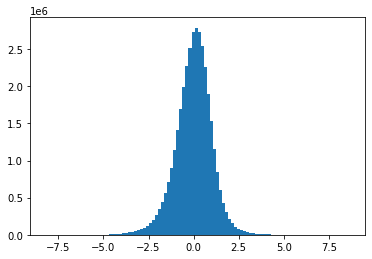

In [12]:
plt.hist(sel_df["normxpehh"], bins=100)
plt.show()

In [19]:
pos_df = pd.read_csv(f"{proj_dir}/results/fig_plotting_info/plotting_info.csv", sep=",") #generated in prep_figs_info.ipynb

offsets=dict(zip(pos_df["contig"], pos_df["x_start"].astype(int)))
colors=dict(zip(pos_df["contig"], pos_df["color"].astype(str)))

x=[]
c=[]

for index, row in tqdm(sel_df.iterrows()):
    snv_id=row["id"]
    chrom = row["chr"]
    
    offset=offsets[chrom]
    color = colors[chrom]
    
    x.append(row["pos"] + offset)
    c.append(color)
    
sel_df["genomic_position"] = x
sel_df["color"] = c

35812528it [20:28, 29153.70it/s]


In [ ]:
sel_df.to_csv("sel_df_norm.csv", sep=",", header=True, index=False)

In [54]:
bed = sel_df[["chr", "pos", "pos", "normxpehh"]]
bed.columns=["chr", "start", "stop", "normxpehh"]
bed["stop"] = bed["start"] + 1
bed.to_csv("sel_df.bed", sep="\t", header=False, index=False)

/tmp/ipykernel_380452/511402116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bed["stop"] = bed["start"] + 1


In [130]:
z_scores = stats.zscore(sel_df["xpehh"])
#sel_df["norm_z_scores"] = z_scores

In [131]:
p_values = stats.norm.sf(np.abs(sel_df["normxpehh"])) * 2  # Two-tailed p-values
sel_df["norm_p_value"] = p_values

sel_df

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,normxpehh,crit,norm_p_value,p_value_bonferroni,fdr,genomic_position,color
0,NC_067195.1,16981,NC_067195.1:16981,16981.0,0.000000,526.758,0.042373,1417.040,-0.429771,-1.81653,0,0.069289,1.0,0.999998,320430638,#7bade3
1,NC_067195.1,16982,NC_067195.1:16982,16982.0,0.012195,514.763,0.000000,1420.990,-0.440983,-1.87203,0,0.061202,1.0,0.973371,320430639,#7bade3
2,NC_067195.1,16993,NC_067195.1:16993,16993.0,0.036585,484.027,0.000000,1420.990,-0.467720,-2.00436,1,0.045032,1.0,0.888875,320430650,#7bade3
3,NC_067195.1,16994,NC_067195.1:16994,16994.0,0.128049,471.285,0.000000,1420.990,-0.479306,-2.06171,1,0.039235,1.0,0.849029,320430651,#7bade3
4,NC_067195.1,16995,NC_067195.1:16995,16995.0,0.006098,474.874,0.000000,1420.990,-0.476012,-2.04540,1,0.040815,1.0,0.859831,320430652,#7bade3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117383,NC_067202.1,19477723,NC_067202.1:19477723,19477700.0,0.000000,398.509,0.000000,270.019,0.169044,1.53885,0,0.123841,1.0,0.999998,317910191,#078d70
2117384,NC_067202.1,19477730,NC_067202.1:19477730,19477700.0,0.036585,396.811,0.000000,270.019,0.167189,1.53106,0,0.125755,1.0,0.999998,317910198,#078d70
2117385,NC_067202.1,19477740,NC_067202.1:19477740,19477700.0,0.000000,409.008,0.000000,270.019,0.180337,1.58626,0,0.112680,1.0,0.999998,317910208,#078d70
2117386,NC_067202.1,19477770,NC_067202.1:19477770,19477800.0,0.390244,333.042,0.245763,207.029,0.206467,1.69596,0,0.089893,1.0,0.999998,317910238,#078d70


In [134]:
# Bonferroni correction
_, p_values_bonferroni, _, _ = smm.multipletests(sel_df["norm_p_value"], method='bonferroni')
sel_df["p_value_bonferroni"] = p_values_bonferroni

# Benjamini-Hochberg correction (False Discovery Rate)
_, fdr, _, _ = smm.multipletests(sel_df["norm_p_value"], method='fdr_bh')
sel_df["fdr"] = fdr

In [135]:
sel_df.to_csv("sel_df_norm.csv", sep=",", header=True, index=False)

In [27]:
alpha = 0.05
sig_bonf = sel_df[sel_df["p_value_bonferroni"] < alpha]
sig_fdr = sel_df[sel_df["fdr"] < alpha]

In [28]:
sig_bonf

,chr,pos,id,gpos,p1,ihh1,p2,ihh2,xpehh,normxpehh,crit,norm_p_value,p_value_bonferroni,fdr,genomic_position,color
581,NC_067195.1,85440,NC_067195.1:85440,85440.0,0.067073,17669.20,0.203390,1093.0900,1.20856,6.29241,1,3.125746e-10,0.011194,0.000022,320499097,#7bade3
582,NC_067195.1,85469,NC_067195.1:85469,85469.0,0.000000,17846.90,0.000000,1216.4200,1.16648,6.08413,1,1.171255e-09,0.041946,0.000045,320499126,#7bade3
583,NC_067195.1,85471,NC_067195.1:85471,85471.0,0.006098,17844.00,0.000000,1216.4200,1.16641,6.08378,1,1.173816e-09,0.042037,0.000045,320499128,#7bade3
584,NC_067195.1,85477,NC_067195.1:85477,85477.0,0.000000,17844.40,0.000000,1216.4200,1.16642,6.08383,1,1.173450e-09,0.042024,0.000045,320499134,#7bade3
585,NC_067195.1,85480,NC_067195.1:85480,85480.0,0.000000,17844.40,0.000000,1216.4200,1.16642,6.08383,1,1.173450e-09,0.042024,0.000045,320499137,#7bade3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041856,NC_067202.1,18613621,NC_067202.1:18613621,18613600.0,0.000000,2354.28,0.000000,120.0760,1.29240,6.25489,1,3.977962e-10,0.014246,0.000024,317046089,#078d70
2041857,NC_067202.1,18613622,NC_067202.1:18613622,18613600.0,0.000000,2354.28,0.144068,114.8890,1.31158,6.33541,1,2.367110e-10,0.008477,0.000019,317046090,#078d70
2041861,NC_067202.1,18613632,NC_067202.1:18613632,18613600.0,0.000000,2353.65,0.093220,122.1220,1.28495,6.22362,1,4.858129e-10,0.017398,0.000026,317046100,#078d70
2041862,NC_067202.1,18613640,NC_067202.1:18613640,18613600.0,0.000000,2353.65,0.084746,132.2120,1.25047,6.07886,1,1.210400e-09,0.043347,0.000046,317046108,#078d70


In [36]:
sig_bonf.to_csv("sel_df_norm_sig_bonf.csv", header=True, index=False, sep=",")

In [29]:
sig_bonf["chr"].value_counts()

NC_067200.1    352
NC_067195.1    286
NC_067199.1    278
NC_067196.1     38
NC_067198.1     19
NC_067197.1     13
NC_067202.1     10
Name: chr, dtype: int64

In [34]:
abs(sig_bonf["normxpehh"]).min()

6.05713

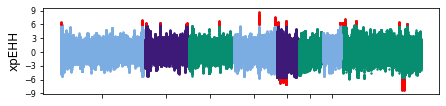

In [35]:
#plot the results
#fig, ax = plt.subplots()

# Create the Manhattan plot figure and axis
cm = 1/2.54
fig, ax = plt.subplots(figsize=(16*cm, 4*cm), facecolor="white")

# Define three shades of grey
shades_of_grey = ['#808080', '#A0A0A0', '#C0C0C0']
mlm_colors= ["#078d70", "#7bade3", "#3e1a78"]

# Create the colormap
custom_cmap = ListedColormap(mlm_colors)

#plot position of the invadolysin locus
#plt.axvline(x=invad_loc, ymin=-3, ymax=3)

# Iterate through the groups of chromosomes and plot each group with a different color

for i, (chrom, group) in enumerate(sel_df.groupby("chr")):
    color = custom_cmap(i % custom_cmap.N)  # Get a color from the colormap
    ax.scatter(group["genomic_position"], group["normxpehh"], s=2, alpha=1, color=color, label=f'{chrom}', zorder=2)

# # Plot the significant data points (Bonferroni corrected) in red
ax.scatter(sig_bonf["genomic_position"], sig_bonf["normxpehh"], s=2, alpha=1, color='red', label='Sig.', zorder=3)

# # Set the x-axis and y-axis labels
#ax.set_xlabel("Genomic Position", fontsize=12)
ax.set_ylabel("xpEHH", fontsize=12)
ax.tick_params(axis='y', labelsize=8)

x_ticks =list(pos_df["mid_tick"].astype(int)[0:7])
x_labels =list(pos_df["contig"].astype(str)[0:7])
y_ticks = list(range(-9, 10, 3))
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels([])
                     
#ax.axhline(y=sig_bonf["xpehh"][sig_bonf["xpehh"]>0].min(), color='black', linestyle="dashed", linewidth=0.5)
#ax.axhline(y=sig_bonf["xpehh"][sig_bonf["xpehh"]<0].max(), color='black', linestyle="dashed", linewidth=0.5)

#plot invadolysin line
#ax.axvline(x=invad_loc_x, color='tomato', linestyle="solid", linewidth=1, zorder=1)


# Add the legend outside the plot in the upper right corner
#ax.legend(markerscale=3, fontsize=12, loc='upper left')

# Adjust the layout to fit the plot in the figure
plt.tight_layout()


# Save the plot as an SVG file
#fig.savefig('nw_vs_se_xpehh_norm.svg', format='svg')

# Save the plot as a 300 dpi PNG file
fig.savefig('nw_vs_se_xpehh_norm.png', format='png', dpi=300, bbox_inches='tight')



# regions under selection

In [42]:
bed = sig_bonf[["chr", "pos", "pos", "normxpehh"]]
bed.columns=["chr", "start", "stop", "normxpehh"]
bed["stop"] = bed["start"] + 1
bed.to_csv("sel_df_norm_sig_bonf.bed", sep="\t", header=False, index=False)

/tmp/ipykernel_380452/435702102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bed["stop"] = bed["start"] + 1


In [69]:
!conda run -n bedtools bedtools cluster -d 1000000 -i sel_df_norm_sig_bonf.bed >sel_df_norm_sig_bonf_clusters.bed

In [70]:
r_df = pd.read_csv("sel_df_norm_sig_bonf_clusters.bed", header=None, sep="\t")
r_df.columns=["chr", "start", "stop", "normxpehh", "cluster"]

In [108]:
nxpehh = list(r_df.groupby("cluster")["normxpehh"].median())
start = list(r_df.groupby("cluster")["start"].min())
stop = list(r_df.groupby("cluster")["stop"].max())
counts = list(r_df.groupby("cluster")["normxpehh"].count())

In [109]:
cluster_df = r_df[["chr", "cluster"]].drop_duplicates().reset_index(drop=True)
cluster_df["start"] = start
cluster_df["stop"] = stop
cluster_df["med_norm_xpehh"] = nxpehh
cluster_df["len"] = cluster_df["stop"]- cluster_df["start"]
cluster_df["sig_snvs"] = counts

cluster_df

,chr,cluster,start,stop,med_norm_xpehh,len,sig_snvs
0,NC_067195.1,1,85440,86575,6.168670,1135,14
1,NC_067195.1,2,2450744,2702312,6.369370,251568,35
2,NC_067195.1,3,15451924,15451973,6.432380,49,9
3,NC_067195.1,4,64303350,64481575,6.192720,178225,35
4,NC_067195.1,5,67218409,67220075,-6.708680,1666,129
5,NC_067195.1,6,69543706,70097099,-6.810760,553393,62
6,NC_067195.1,7,72947731,72947748,6.159410,17,2
7,NC_067196.1,8,335206,335218,6.191205,12,6
8,NC_067196.1,9,92138959,92139077,6.151370,118,32
9,NC_067197.1,10,1449094,1449134,6.114800,40,3


In [129]:
size_df = pd.read_csv("../../data/GCF_000699445.3_UoM_Shae.V3_genomic.fna.fai", sep='\t', header=None, names=['sequence_name', 'length', 'offset', 'linebases', 'linewidth'])
size_dict = dict(zip(size_df['sequence_name'], size_df['length']))
size_df.head()

,sequence_name,length,offset,linebases,linewidth
0,NC_067195.1,89168492,82,80,81
1,NC_067196.1,93306550,90283262,80,81
2,NC_067197.1,47367863,184756225,80,81
3,NC_067198.1,48328128,232716268,80,81
4,NC_067199.1,46771736,281648579,80,81


In [112]:
size_dict = dict(zip(size_df['sequence_name'], size_df['length']))

In [127]:
bps=[]
percs=[]
locations=[]

for index, row in cluster_df.iterrows():

    chrom = row["chr"]
    start = row["start"]
    stop = row["stop"]
    chrom_size = size_dict[chrom]
    
    locations.append(f"{chrom}:{start}-{stop}")


    bp = min([start, chrom_size-stop])
    perc = bp/chrom_size

    bps.append(bp)
    percs.append(perc)


cluster_df["bp_to_end"] = bps
cluster_df["perc_to_end"]=percs
cluster_df["location"] = locations


cluster_df.to_csv("xpehh_outlier_windows.csv")
cluster_df

,chr,cluster,start,stop,med_norm_xpehh,len,sig_snvs,bp_to_end,perc_to_end,location
0,NC_067195.1,1,85440,86575,6.168670,1135,14,85440,0.000958,NC_067195.1:85440-86575
1,NC_067195.1,2,2450744,2702312,6.369370,251568,35,2450744,0.027484,NC_067195.1:2450744-2702312
2,NC_067195.1,3,15451924,15451973,6.432380,49,9,15451924,0.173289,NC_067195.1:15451924-15451973
3,NC_067195.1,4,64303350,64481575,6.192720,178225,35,24686917,0.276857,NC_067195.1:64303350-64481575
4,NC_067195.1,5,67218409,67220075,-6.708680,1666,129,21948417,0.246145,NC_067195.1:67218409-67220075
5,NC_067195.1,6,69543706,70097099,-6.810760,553393,62,19071393,0.213880,NC_067195.1:69543706-70097099
6,NC_067195.1,7,72947731,72947748,6.159410,17,2,16220744,0.181911,NC_067195.1:72947731-72947748
7,NC_067196.1,8,335206,335218,6.191205,12,6,335206,0.003593,NC_067196.1:335206-335218
8,NC_067196.1,9,92138959,92139077,6.151370,118,32,1167473,0.012512,NC_067196.1:92138959-92139077
9,NC_067197.1,10,1449094,1449134,6.114800,40,3,1449094,0.030592,NC_067197.1:1449094-1449134
